<a href="https://colab.research.google.com/github/ipsitapatra7149/age_predict_diabetes/blob/main/age_predict_30_mar(updated%204%20model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Shape: (266, 40)

Missing Values:
Age Group                                        0
Gender                                           0
Height                                           0
Weight                                           0
Current Occupation                               0
Age at Diagnosis                                 0
Fasting Blood Sugar                              0
Postprandial Blood Sugar                         0
Average Blood sugar in 3 months                  0
HbA1c Levels                                     0
Use of Medication                               59
Frequency of Doctor Visits                       0
Frequency of Blood Sugar Testing                 0
Other Chronic Conditions                        56
Meal Frequency                                   0
Sugar Consumption                                0
Oily Food Consumption                            0
Processed Food Consumption                       0
Food Source Preference                     

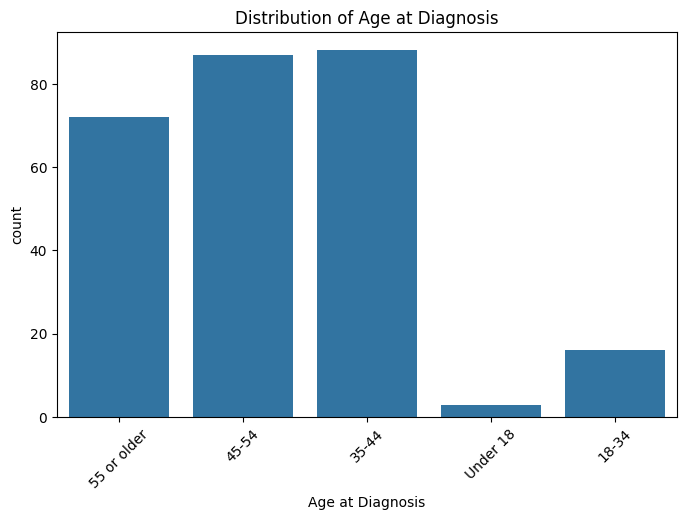


Model Performance:
Mean Absolute Error (MAE): 9.48
Mean Squared Error (MSE): 126.09
Root Mean Squared Error (RMSE): 11.23
R-squared (R²): 0.23

Top 20 Features by Importance:
                                               Feature  Importance
82                     Maternal_Age at Diagnosis_18-34    0.082129
104              Maternal_Dietary Pattern_High Protein    0.048905
28                  Frequency of Doctor Visits_Monthly    0.044101
43           Meal Frequency_Rarely, I often skip meals    0.037609
155   Financial Burden of Diabetes Treatment_Very high    0.036581
6                                      Age Group_35-44    0.035544
133                Paternal_Dietary Pattern_High Sugar    0.034965
5                                      Age Group_25-34    0.031238
107  Maternal_Dietary Pattern_Keto/Low Carb High Fa...    0.024624
145  Stress Levels Related to Diabetes Management_V...    0.020689
149  Support from Family and Friends_Not very suppo...    0.018450
142  Stress Levels R

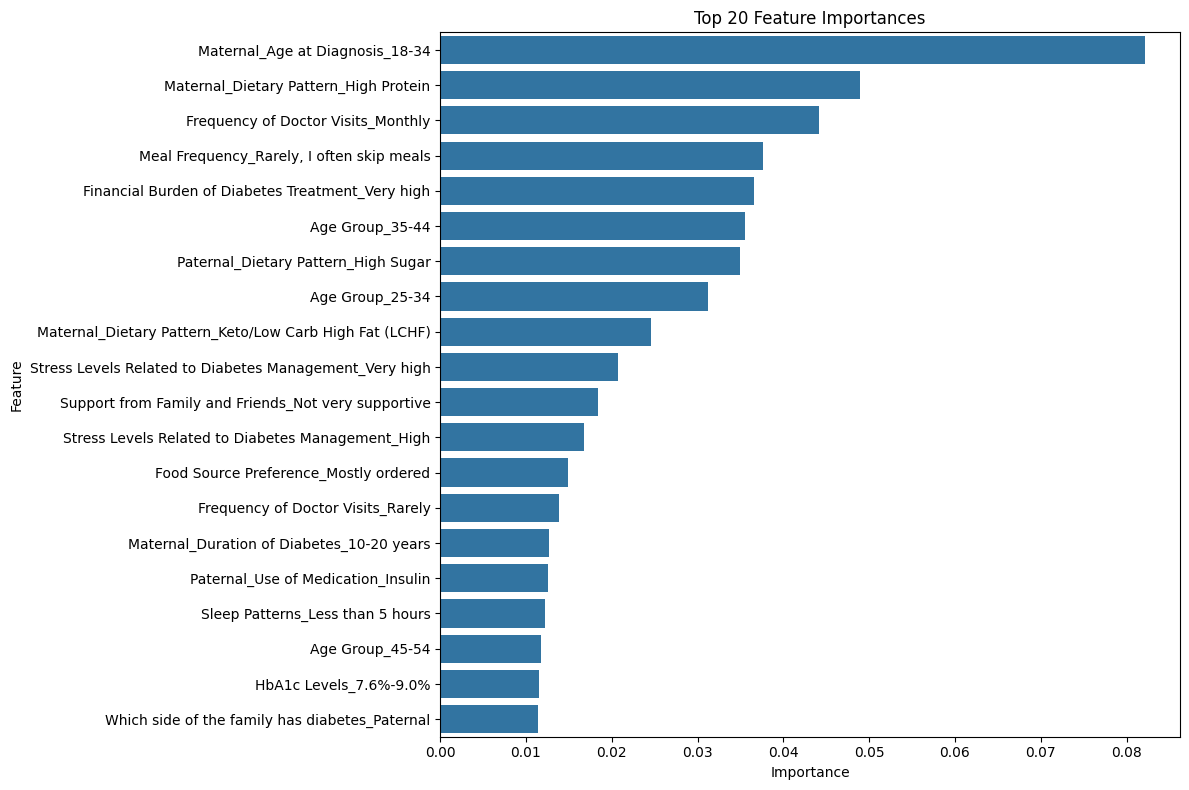

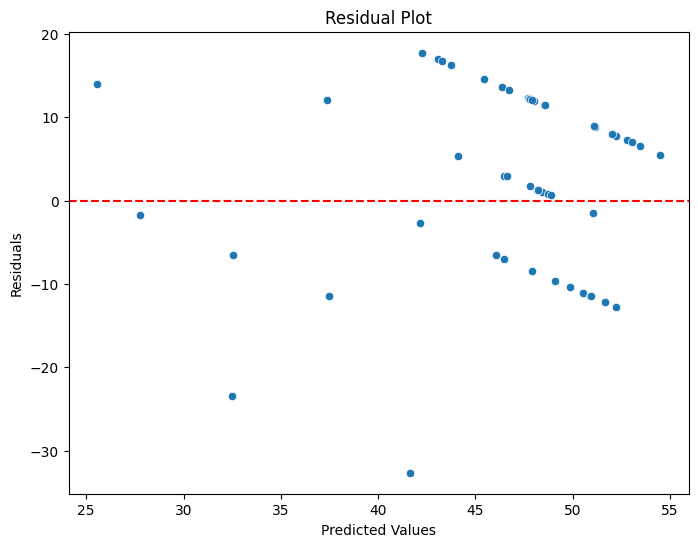

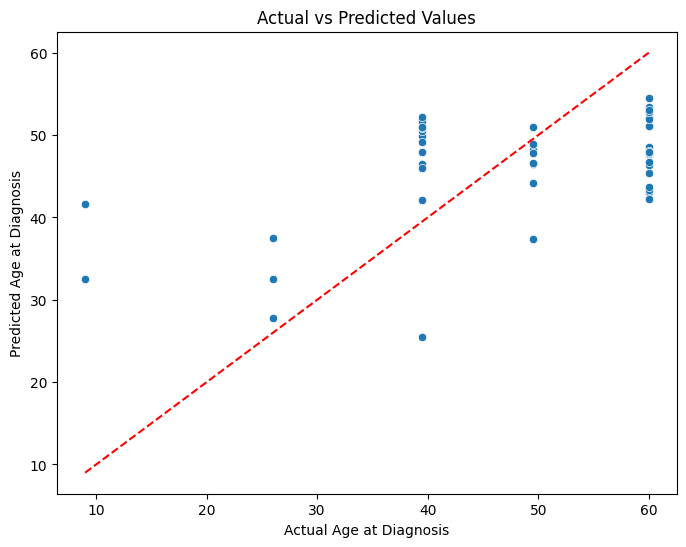

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
file_path = "Diabetic_Merged.xlsx"
df = pd.read_excel(file_path)

# Data Exploration
print("Data Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
print(df.describe(include='all'))

# Target variable distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Age at Diagnosis', data=df)
plt.title('Distribution of Age at Diagnosis')
plt.xticks(rotation=45)
plt.show()

# Convert Age at Diagnosis to numerical (taking midpoint of ranges)
def age_to_numeric(x):
    if pd.isna(x):
        return np.nan
    if x == 'Under 18':
        return 9
    elif x == '18-34':
        return (18 + 34)/2
    elif x == '35-44':
        return (35 + 44)/2
    elif x == '45-54':
        return (45 + 54)/2
    elif x == '55 or older':
        return 60  # Approximation
    else:
        return np.nan

df['Age_at_Diagnosis_numeric'] = df['Age at Diagnosis'].apply(age_to_numeric)

# Split data
X = df.drop(columns=['Age at Diagnosis', 'Age_at_Diagnosis_numeric'])
y = df['Age_at_Diagnosis_numeric']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Feature Engineering functions
def create_features(data):
    data = data.copy()
    # Create BMI feature
    data['BMI'] = data['Weight'] / ((data['Height']/100) ** 2)

    # Convert HbA1c to numerical
    def hba1c_to_numeric(x):
        if pd.isna(x):
            return np.nan
        if x == 'Below 5.7%':
            return 5.35
        elif x == '5.7%-6.4%':
            return (5.7 + 6.4)/2
        elif x == '6.5%-7.5%':
            return (6.5 + 7.5)/2
        elif x == '7.6%-9.0%':
            return (7.6 + 9.0)/2
        elif x == '9.1% or higher':
            return 9.5
        else:
            return np.nan

    data['HbA1c_numeric'] = data['HbA1c Levels'].apply(hba1c_to_numeric)
    return data

# Apply feature engineering separately to train and test
X_train = create_features(X_train)
X_test = create_features(X_test)

# Identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Remove engineered features from numeric features
numeric_features = [f for f in numeric_features if f not in ['BMI', 'HbA1c_numeric']]

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('new_features', 'passthrough', ['BMI', 'HbA1c_numeric'])
    ])

# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=42,
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mae'
    ))
])

# Fit model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Feature Importance
onehot_columns = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(onehot_columns) + ['BMI', 'HbA1c_numeric']

importances = model.named_steps['regressor'].feature_importances_

feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 Features by Importance:")
print(feature_importance.head(20))

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Actual vs Predicted plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Age at Diagnosis')
plt.ylabel('Predicted Age at Diagnosis')
plt.show()

In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.3 MB/s eta 0:00:00


[I 2025-04-03 17:35:24,588] A new study created in memory with name: no-name-3b3972b3-e157-4e41-8ec5-6c2f7ed5f1e4


Data Shape: (266, 40)

Missing Values:
Age Group                                        0
Gender                                           0
Height                                           0
Weight                                           0
Current Occupation                               0
Age at Diagnosis                                 0
Fasting Blood Sugar                              0
Postprandial Blood Sugar                         0
Average Blood sugar in 3 months                  0
HbA1c Levels                                     0
Use of Medication                               59
Frequency of Doctor Visits                       0
Frequency of Blood Sugar Testing                 0
Other Chronic Conditions                        56
Meal Frequency                                   0
Sugar Consumption                                0
Oily Food Consumption                            0
Processed Food Consumption                       0
Food Source Preference                     

[I 2025-04-03 17:35:26,523] Trial 0 finished with value: 7.799665761970867 and parameters: {'n_estimators': 253, 'learning_rate': 0.07097817163248307, 'max_depth': 7, 'subsample': 0.6088816355043837, 'colsample_bytree': 0.8409804468538873, 'reg_alpha': 0.5547179678037513, 'reg_lambda': 5.657861114565064}. Best is trial 0 with value: 7.799665761970867.
[I 2025-04-03 17:35:28,968] Trial 1 finished with value: 7.582422515852244 and parameters: {'n_estimators': 482, 'learning_rate': 0.036921269078466164, 'max_depth': 10, 'subsample': 0.9471785318632131, 'colsample_bytree': 0.8181395704957726, 'reg_alpha': 7.883438968266289, 'reg_lambda': 0.42815943770781506}. Best is trial 1 with value: 7.582422515852244.
[I 2025-04-03 17:35:30,145] Trial 2 finished with value: 7.993130971374174 and parameters: {'n_estimators': 264, 'learning_rate': 0.14895503925371598, 'max_depth': 7, 'subsample': 0.6973109335123773, 'colsample_bytree': 0.6788463159316229, 'reg_alpha': 8.188667202042106, 'reg_lambda': 9.7

Best Parameters: {'n_estimators': 484, 'learning_rate': 0.01094192697214192, 'max_depth': 10, 'subsample': 0.7255040713779435, 'colsample_bytree': 0.6502550814740008, 'reg_alpha': 5.407940952953431, 'reg_lambda': 1.0903252804061072}

Model Performance:
Mean Absolute Error (MAE): 9.35
Root Mean Squared Error (RMSE): 10.92
R-squared (R²): 0.27


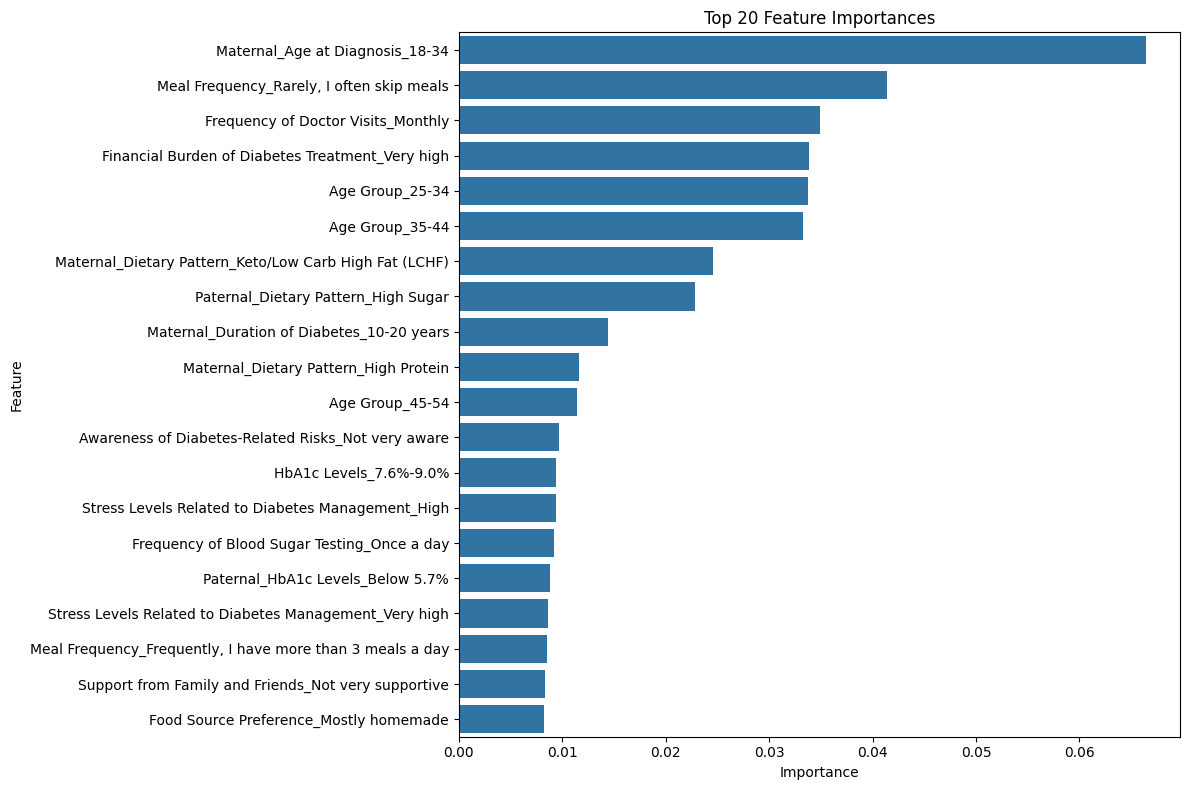

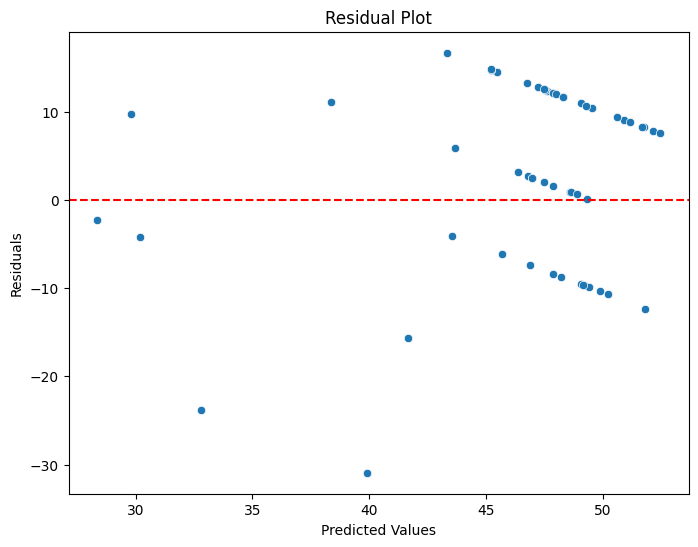

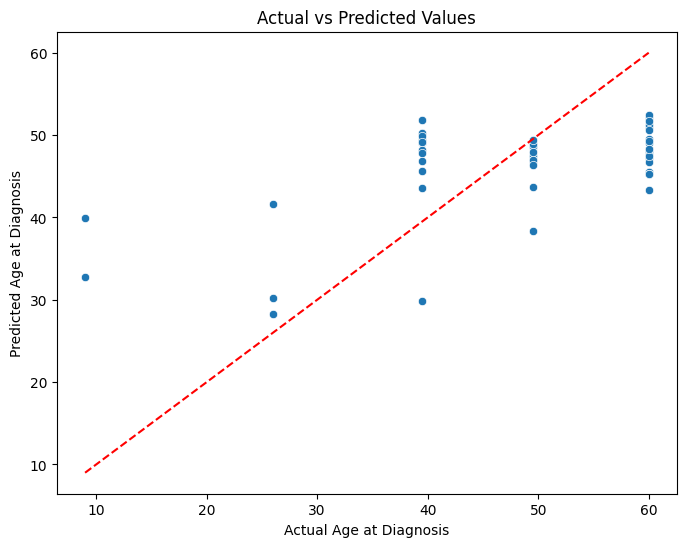

In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
file_path = "Diabetic_Merged.xlsx"
df = pd.read_excel(file_path)

# Data Exploration
print("Data Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())

# Convert Age at Diagnosis to numerical (taking midpoint of ranges)
def age_to_numeric(x):
    if pd.isna(x):
        return np.nan
    age_map = {
        'Under 18': 9, '18-34': (18 + 34)/2, '35-44': (35 + 44)/2,
        '45-54': (45 + 54)/2, '55 or older': 60
    }
    return age_map.get(x, np.nan)

df['Age_at_Diagnosis_numeric'] = df['Age at Diagnosis'].apply(age_to_numeric)

# Split data
X = df.drop(columns=['Age at Diagnosis', 'Age_at_Diagnosis_numeric'])
y = df['Age_at_Diagnosis_numeric']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Feature Engineering functions
def create_features(data):
    data = data.copy()
    data['BMI'] = data['Weight'] / ((data['Height']/100) ** 2)

    hba1c_map = {
        'Below 5.7%': 5.35, '5.7%-6.4%': (5.7 + 6.4)/2,
        '6.5%-7.5%': (6.5 + 7.5)/2, '7.6%-9.0%': (7.6 + 9.0)/2,
        '9.1% or higher': 9.5
    }
    data['HbA1c_numeric'] = data['HbA1c Levels'].map(hba1c_map)
    return data

X_train = create_features(X_train)
X_test = create_features(X_test)

# Identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = [f for f in numeric_features if f not in ['BMI', 'HbA1c_numeric']]

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('new_features', 'passthrough', ['BMI', 'HbA1c_numeric'])
    ])

# **Hyperparameter Tuning with Optuna**
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),  # **L1 Regularization**
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),  # **L2 Regularization**
        'eval_metric': 'mae',
        'random_state': 42
    }

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(**params))
    ])

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    return -np.mean(scores)  # Minimize MAE

# **Run Bayesian Optimization**
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# **Use Best Parameters**
best_params = study.best_params
print("Best Parameters:", best_params)

# **Final Model with Best Hyperparameters**
xgb_regressor = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],  # L1 Regularization
    reg_lambda=best_params['reg_lambda'],  # L2 Regularization
    eval_metric='mae',
    random_state=42
)

# **Final Pipeline**
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_regressor)
])

# **Train Model**
model.fit(X_train, y_train)

# **Predictions**
y_pred = model.predict(X_test)

# **Evaluation**
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# **Feature Importance**
onehot_columns = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(onehot_columns) + ['BMI', 'HbA1c_numeric']
importances = model.named_steps['regressor'].feature_importances_

feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# **Feature Importance Plot**
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# **Residual Plot**
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# **Actual vs Predicted**
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Age at Diagnosis')
plt.ylabel('Predicted Age at Diagnosis')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
file_path = "Diabetic_Merged.xlsx"
df = pd.read_excel(file_path)

# Convert Age at Diagnosis to numerical (taking midpoint of ranges)
def age_to_numeric(x):
    if pd.isna(x):
        return np.nan
    if x == 'Under 18':
        return 9
    elif x == '18-34':
        return (18 + 34)/2
    elif x == '35-44':
        return (35 + 44)/2
    elif x == '45-54':
        return (45 + 54)/2
    elif x == '55 or older':
        return 60  # Approximation
    else:
        return np.nan

df['Age_at_Diagnosis_numeric'] = df['Age at Diagnosis'].apply(age_to_numeric)

# Apply log transformation to target variable
df['Age_at_Diagnosis_numeric'] = np.log1p(df['Age_at_Diagnosis_numeric'])

# Split data
X = df.drop(columns=['Age at Diagnosis', 'Age_at_Diagnosis_numeric'])
y = df['Age_at_Diagnosis_numeric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering
def create_features(data):
    data = data.copy()
    data['BMI'] = data['Weight'] / ((data['Height']/100) ** 2)

    def hba1c_to_numeric(x):
        if pd.isna(x):
            return np.nan
        if x == 'Below 5.7%':
            return 5.35
        elif x == '5.7%-6.4%':
            return (5.7 + 6.4)/2
        elif x == '6.5%-7.5%':
            return (6.5 + 7.5)/2
        elif x == '7.6%-9.0%':
            return (7.6 + 9.0)/2
        elif x == '9.1% or higher':
            return 9.5
        else:
            return np.nan

    data['HbA1c_numeric'] = data['HbA1c Levels'].apply(hba1c_to_numeric)
    return data

X_train = create_features(X_train)
X_test = create_features(X_test)

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = [f for f in numeric_features if f not in ['BMI', 'HbA1c_numeric']]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('new_features', 'passthrough', ['BMI', 'HbA1c_numeric'])
    ])

# Optuna Hyperparameter Tuning
def objective(trial):
    model_choice = trial.suggest_categorical("model", ["xgb", "lgbm"])

    if model_choice == "xgb":
        model = XGBRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 500, step=50),
            learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            subsample=trial.suggest_uniform("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
            reg_alpha=trial.suggest_loguniform("reg_alpha", 1e-3, 10),
            reg_lambda=trial.suggest_loguniform("reg_lambda", 1e-3, 10),
            random_state=42,
            eval_metric='mae'
        )
    else:
        model = LGBMRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 500, step=50),
            learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            subsample=trial.suggest_uniform("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
            reg_alpha=trial.suggest_loguniform("reg_alpha", 1e-3, 10),
            reg_lambda=trial.suggest_loguniform("reg_lambda", 1e-3, 10),
            random_state=42
        )

    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    return -np.mean(scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Increased to 100 trials

# Train best model
best_params = study.best_params
print("Best Hyperparameters:", best_params)

if best_params["model"] == "xgb":
    final_model = XGBRegressor(**{k: v for k, v in best_params.items() if k != "model"}, random_state=42)
else:
    final_model = LGBMRegressor(**{k: v for k, v in best_params.items() if k != "model"}, random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', final_model)])
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_pred = np.expm1(y_pred)  # Convert back from log scale

# Evaluation Metrics
mae = mean_absolute_error(np.expm1(y_test), y_pred)
mse = mean_squared_error(np.expm1(y_test), y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.expm1(y_test), y_pred)

print("\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


[I 2025-04-03 17:41:44,567] A new study created in memory with name: no-name-ff1b3a18-96e8-46ae-b76a-61615af4e504
<ipython-input-6-9db30069dd49>:99: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
<ipython-input-6-9db30069dd49>:101: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform("subsample", 0.6, 1.0),
<ipython-input-6-9db30069dd49>:102: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree=trial.suggest_uniform("colsample_bytree", 0.6, 1.0),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 117
[LightGBM] [Info] Start training from score 3.840425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-03 17:41:50,11

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-03 17:41:50,640] Trial 3 finished with value: 0.19351897181875222 and parameters: {'model': 'lgbm', 'n_estimators': 300, 'learning_rate': 0.035064255783422295, 'max_depth': 7, 'subsample': 0.9301029748165736, 'colsample_bytree': 0.9224618771581639, 'reg_alpha': 0.16759565116427694, 'reg_lambda': 0.07815913777094463}. Best is trial 0 with value: 0.16895220365241329.
<ipython-input-6-9db30069dd49>:111: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
<ipython-input-6-9db30069dd49>:113: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 117
[LightGBM] [Info] Start training from score 3.838190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-03 17:41:51,283] Trial 5 finished with value: 0.18058082745238954 and parameters: {'model': 'lgbm', 'n_estimators': 100, 'learning_rate': 0.01090107570248899, 'max_depth': 7, 'subsample': 0.61616606613001, 'co

[LightGBM] [Info] Start training from score 3.853903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-04-03 17:41:53,563] Trial 6 finished with value: 0.16510629699202634 and parameters: {'model': 'xgb', 'n_estimators': 300, 'learning_rate': 0.020373905364179337, 'max_depth': 8, 'subsample': 0.9322303245464267, 'colsample_bytree': 0.7804768403667639, 'reg_alpha': 0.1717865261600549, 'reg_lambda': 1.6409279138863826}. Best is trial 6 with value: 0.16510629699202634.
<ipython-input-6-9db30069dd49>:111: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
<ipython-input-6-9db30069dd49>:113: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform("subsample", 0.6, 1.0),
<ipython-input-6-9db30069dd49>:1

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 117
[LightGBM] [Info] Start training from score 3.840425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-03 17:41:54,02

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 117
[LightGBM] [Info] Start training from score 3.840425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-03 17:41:54,44

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 117
[LightGBM] [Info] Start training from score 3.835512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 117
[LightGBM] [Info] Start training from score 3.835162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-03 17:41:55,123] Trial 9 finished with value: 0.21298806592944902 and parameters: {'model': 'lgbm', 'n_estimators': 500, 'learning_rate': 0.16941444319721008, 'max_depth': 10, 'subsample': 0.8389206259867015, 'colsample_bytree': 0.7236482785883389, 'reg_alpha': 0.013932767037543536, 'reg_lambda': 3.013683315117823}. Best is trial 6 with value: 0.16510629699202634.
<ipython-input-6-9db30069dd49>:99: Fu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 117
[LightGBM] [Info] Start training from score 3.853903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-04-03 17:41:56,955] Trial 10 finished with value: 0.16722937934574456 and parameters: {'model': 'xgb', 'n_estimators': 400, 'learning_rate': 0.0727822304277164, 'max_depth': 8, 'subsample': 0.9926324138061573, 'colsample_bytree': 0.8424177877644883, 'reg_alpha': 0.0015755400647202206, 'reg_lambda': 0.6699227170318782}. Best is trial 6 with value: 0.16510629699202634.
<ipython-input-6-9db30069dd49>:99: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
<ipython-input-6-9db30069dd49>:101: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform("subsample", 0.6, 1.0),
<ipython-input-6-9db30069dd49>:

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 117
[LightGBM] [Info] Start training from score 3.840425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-03 17:42:38,649] Trial 37 finished with value: 0.18140779886369657 and parameters: {'model': 'lgbm', 'n_estimators': 100, 'learning_rate': 0.02451566407328096, 'max_depth': 3, 'subsample': 0.6105349225984709, 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 117
[LightGBM] [Info] Start training from score 3.853903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-04-03 17:42:42,131] Trial 38 finished with value: 0.16991092809820288 and parameters: {'model': 'xgb', 'n_estimators': 450, 'learning_rate': 0.014882037731817706, 'max_depth': 7, 'subsample': 0.7531247011138937, 'colsample_bytree': 0.9815538558473343, 'reg_alpha': 0.013954368047649714, 'reg_lambda': 0.09265664904068932}. Best is trial 23 with value: 0.1626973810868971.
<ipython-input-6-9db30069dd49>:111: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
<ipython-input-6-9db30069dd49>:113: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform("subsample", 0.6, 1.0),
<ipython-input-6-9db30069dd4

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 117
[LightGBM] [Info] Start training from score 3.840425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 117
[LightGBM] [Info] Start training from score 3.835512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

<ipython-input-6-9db30069dd49>:99: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
<ipython-input-6-9db30069dd49>:101: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform("subsample", 0.6, 1.0),
<ipython-input-6-9db30069dd49>:102: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree=trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
<ipython-input-6-9db30069dd49>:103: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 117
[LightGBM] [Info] Start training from score 3.840425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-03 17:42:49,17

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 117
[LightGBM] [Info] Start training from score 3.835512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-04-03 17:42:50,610] Trial 45 finished with value: 0.1699944995396167 and parameters: {'model': 'xgb', 'n_estimators': 250, 'learning_rate': 0.017903060213038252, 'max_depth': 6, 'subsample': 0.6658275403236087, 'colsample_bytree': 0.8201821500723543, 'reg_alpha': 0.026572150551627816, 'reg_lambda': 0.019391390932783765}. Best is trial 23 with value: 0.1626973810868971.
<ipython-input-6-9db30069dd49>:99: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
<ipython-input-6-9db30069dd49>:101: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform("subsample", 0.6, 1.0),
<ipython-input-6-9db30069dd49

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 117
[LightGBM] [Info] Start training from score 3.840425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 117
[LightGBM] [Info] Start training from score 3.835512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

<ipython-input-6-9db30069dd49>:99: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
<ipython-input-6-9db30069dd49>:101: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform("subsample", 0.6, 1.0),
<ipython-input-6-9db30069dd49>:102: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree=trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
<ipython-input-6-9db30069dd49>:103: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 117
[LightGBM] [Info] Start training from score 3.840425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-03 17:43:08,647] Trial 58 finished with value: 0.18068293156881943 and parameters: {'model': 'lgbm', 'n_estimators': 100, 'learning_rate': 0.0229006008505478, 'max_depth': 8, 'subsample': 0.6440427509237726, '

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-03 17:43:11,425] Trial 59 finished with value: 0.16119524830304954 and parameters: {'model': 'xgb', 'n_estimators': 100, 'learning_rate': 0.036142497233612916, 'max_depth': 10, 'subsample': 0.6188419289059466, 'colsample_bytree': 0.7572796658507298, 'reg_alpha': 0.0028081099602695362, 'reg_lambda': 0.03729473805902899}. Best is trial 59 with value: 0.16119524830304954.
<ipython-input-6-9db30069dd49>:99: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
<ipython-input-6-9db30069dd49>:101: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform("subsample", 0.6, 1.0),
<ipython-input-6-9db30069d

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 117
[LightGBM] [Info] Start training from score 3.840425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-03 17:43:40,57

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-03 17:43:46,766] Trial 79 finished with value: 0.16501356647515114 and parameters: {'model': 'xgb', 'n_estimators': 450, 'learning_rate': 0.018295512560425702, 'max_depth': 9, 'subsample': 0.8985744993993992, 'colsample_bytree': 0.9585664149021853, 'reg_alpha': 0.010105507802186326, 'reg_lambda': 0.19001113058811747}. Best is trial 59 with value: 0.16119524830304954.
<ipython-input-6-9db30069dd49>:99: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
<ipython-input-6-9db30069dd49>:101: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform("subsample", 0.6, 1.0),
<ipython-input-6-9db30069dd4

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 117
[LightGBM] [Info] Start training from score 3.840425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-03 17:44:08,209] Trial 90 finished with value: 0.1805832862098097 and parameters: {'model': 'lgbm', 'n_estimators': 100, 'learning_rate': 0.027196377570940716, 'max_depth': 7, 'subsample': 0.600219186329338, '

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 117
[LightGBM] [Info] Start training from score 3.853903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-04-03 17:44:11,351] Trial 91 finished with value: 0.16204364636790342 and parameters: {'model': 'xgb', 'n_estimators': 150, 'learning_rate': 0.018253105752146358, 'max_depth': 10, 'subsample': 0.6211933555281188, 'colsample_bytree': 0.7479776854421608, 'reg_alpha': 0.0031980459018644295, 'reg_lambda': 0.06147752123365886}. Best is trial 59 with value: 0.16119524830304954.
<ipython-input-6-9db30069dd49>:99: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
<ipython-input-6-9db30069dd49>:101: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform("subsample", 0.6, 1.0),
<ipython-input-6-9db30069d

Best Hyperparameters: {'model': 'xgb', 'n_estimators': 150, 'learning_rate': 0.020190156327743607, 'max_depth': 10, 'subsample': 0.6079262997967989, 'colsample_bytree': 0.8134172498629623, 'reg_alpha': 0.0061048454625271175, 'reg_lambda': 0.027197468877813526}

Model Performance:
Mean Absolute Error (MAE): 9.59
Root Mean Squared Error (RMSE): 10.91
R-squared (R²): 0.27


[I 2025-04-03 18:38:49,456] A new study created in memory with name: no-name-140749d7-d314-4769-9964-fb6779a4be78
[I 2025-04-03 18:38:49,461] Trial 0 finished with value: 7.996446012913815 and parameters: {'model': 'ridge', 'alpha': 0.11729783936345337}. Best is trial 0 with value: 7.996446012913815.
[I 2025-04-03 18:38:49,534] Trial 1 finished with value: 0.02639180642587167 and parameters: {'model': 'xgboost', 'n_estimators': 300, 'learning_rate': 0.0839160657226456, 'max_depth': 4}. Best is trial 1 with value: 0.02639180642587167.
[I 2025-04-03 18:38:49,558] Trial 2 finished with value: 0.3551085083572953 and parameters: {'model': 'xgboost', 'n_estimators': 50, 'learning_rate': 0.1609194967315886, 'max_depth': 5}. Best is trial 1 with value: 0.02639180642587167.
[I 2025-04-03 18:38:49,563] Trial 3 finished with value: 8.01311927011868 and parameters: {'model': 'ridge', 'alpha': 0.5658572874908168}. Best is trial 1 with value: 0.02639180642587167.
[I 2025-04-03 18:38:49,595] Trial 4 


XGBoost Model Performance:
MAE: 9.56
RMSE: 11.04
R²: 0.26

Random Forest Model Performance:
MAE: 9.06
RMSE: 10.57
R²: 0.32

SVR Model Performance:
MAE: 9.90
RMSE: 12.74
R²: 0.01

Stacking Ensemble Model Performance:
MAE: 0.00
RMSE: 0.00
R²: 1.00


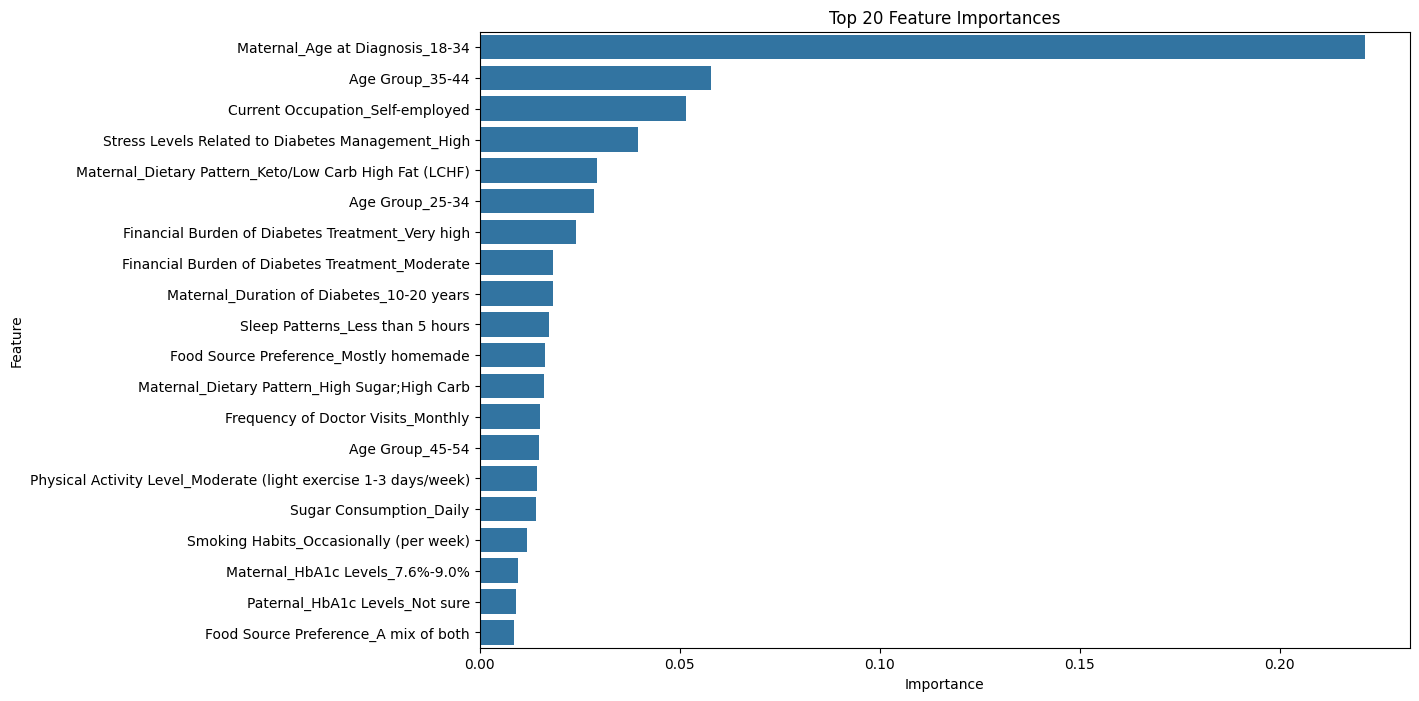

In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
file_path = "Diabetic_Merged.xlsx"
df = pd.read_excel(file_path)

# Convert Age at Diagnosis to numerical
def age_to_numeric(x):
    if pd.isna(x):
        return np.nan
    mapping = {'Under 18': 9, '18-34': 26, '35-44': 39.5, '45-54': 49.5, '55 or older': 60}
    return mapping.get(x, np.nan)

df['Age_at_Diagnosis_numeric'] = df['Age at Diagnosis'].apply(age_to_numeric)
X = df.drop(columns=['Age at Diagnosis', 'Age_at_Diagnosis_numeric'])
y = df['Age_at_Diagnosis_numeric']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering
def create_features(data):
    data = data.copy()
    data['BMI'] = data['Weight'] / ((data['Height'] / 100) ** 2)
    data['Weight_Height_Ratio'] = data['Weight'] / data['Height']

    def hba1c_to_numeric(x):
        if pd.isna(x):
            return np.nan
        mapping = {'Below 5.7%': 5.35, '5.7%-6.4%': 6.05, '6.5%-7.5%': 7.0, '7.6%-9.0%': 8.3, '9.1% or higher': 9.5}
        return mapping.get(x, np.nan)

    data['HbA1c_numeric'] = data['HbA1c Levels'].apply(hba1c_to_numeric)
    data['BMI_HbA1c_Interaction'] = data['BMI'] * data['HbA1c_numeric']
    data.drop(columns=['Height'], inplace=True, errors='ignore')

    return data

X_train = create_features(X_train)
X_test = create_features(X_test)

# Identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
manual_features = ['BMI', 'HbA1c_numeric', 'Weight_Height_Ratio', 'BMI_HbA1c_Interaction']
numeric_features = [f for f in numeric_features if f not in manual_features]

# Preprocessing Pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('manual', 'passthrough', manual_features)
])

# Train Base Models
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42, eval_metric='mae'))
])
xgb_model.fit(X_train, y_train)

rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])
rf_model.fit(X_train, y_train)

svr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf', C=10, epsilon=0.1))
])
svr_model.fit(X_train, y_train)

# Get Base Model Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)

# Stacking Dataset
stack_train = np.column_stack((y_pred_xgb, y_pred_rf, y_pred_svr))

# Hyperparameter Optimization for Meta-Learner
def meta_objective(trial):
    model_type = trial.suggest_categorical("model", ["ridge", "xgboost"])

    if model_type == "ridge":
        alpha = trial.suggest_float("alpha", 0.01, 10.0, log=True)
        meta_model = Ridge(alpha=alpha)
    else:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=50),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
        }
        meta_model = XGBRegressor(**params, random_state=42)

    meta_model.fit(stack_train, y_test)
    stack_pred = meta_model.predict(stack_train)
    return mean_absolute_error(y_test, stack_pred)

study = optuna.create_study(direction="minimize")
study.optimize(meta_objective, n_trials=50)

best_meta_params = study.best_params

# Train Final Meta-Model
if best_meta_params["model"] == "ridge":
    final_meta_model = Ridge(alpha=best_meta_params["alpha"])
else:
    final_meta_model = XGBRegressor(
        n_estimators=best_meta_params["n_estimators"],
        learning_rate=best_meta_params["learning_rate"],
        max_depth=best_meta_params["max_depth"],
        random_state=42
    )

final_meta_model.fit(stack_train, y_test)
stack_pred = final_meta_model.predict(stack_train)

# Evaluation
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{name} Model Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

# Evaluate All Models
evaluate_model("XGBoost", y_test, y_pred_xgb)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("SVR", y_test, y_pred_svr)
evaluate_model("Stacking Ensemble", y_test, stack_pred)

# Feature Importance for XGBoost
onehot_columns = xgb_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(onehot_columns) + manual_features
importances = xgb_model.named_steps['regressor'].feature_importances_

feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.show()
